In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),                # image → tensor [0,1]
    transforms.Normalize(
        (0.5, 0.5, 0.5),                  # mean for RGB
        (0.5, 0.5, 0.5)                   # std for RGB
    )
])


In [20]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


In [21]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./dataset",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./dataset",
    train=False,
    download=True,
    transform=transform
)


Files already downloaded and verified
Files already downloaded and verified


In [22]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)


In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # -------- Block 1 --------
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2)   # 32x32 → 16x16
        )

        # -------- Block 2 --------
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2)   # 16x16 → 8x8
        )

        # -------- Block 3 --------
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2)   # 8x8 → 4x4
        )

        # -------- Classifier --------
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x


In [24]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_accuracies = []

epochs = 10

for epoch in range(epochs):
    # -------- TRAIN --------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # -------- VALIDATION --------
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Loss: {epoch_loss:.4f} | "
        f"Train Acc: {epoch_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


100%|██████████| 782/782 [00:16<00:00, 46.45it/s]


Epoch [1/10] Loss: 1.5469 | Train Acc: 0.4288 | Val Acc: 0.6126


100%|██████████| 782/782 [00:16<00:00, 46.96it/s]


Epoch [2/10] Loss: 1.1823 | Train Acc: 0.5768 | Val Acc: 0.6164


100%|██████████| 782/782 [00:16<00:00, 47.17it/s]


Epoch [3/10] Loss: 1.0264 | Train Acc: 0.6372 | Val Acc: 0.7224


100%|██████████| 782/782 [00:16<00:00, 47.39it/s]


Epoch [4/10] Loss: 0.9362 | Train Acc: 0.6729 | Val Acc: 0.7387


100%|██████████| 782/782 [00:16<00:00, 46.23it/s]


Epoch [5/10] Loss: 0.8707 | Train Acc: 0.6997 | Val Acc: 0.7500


100%|██████████| 782/782 [00:16<00:00, 47.50it/s]


Epoch [6/10] Loss: 0.8204 | Train Acc: 0.7204 | Val Acc: 0.7461


100%|██████████| 782/782 [00:16<00:00, 47.37it/s]


Epoch [7/10] Loss: 0.7746 | Train Acc: 0.7347 | Val Acc: 0.7765


100%|██████████| 782/782 [00:16<00:00, 47.46it/s]


Epoch [8/10] Loss: 0.7362 | Train Acc: 0.7508 | Val Acc: 0.7662


100%|██████████| 782/782 [00:16<00:00, 47.58it/s]


Epoch [9/10] Loss: 0.6971 | Train Acc: 0.7641 | Val Acc: 0.8085


100%|██████████| 782/782 [00:16<00:00, 47.26it/s]


Epoch [10/10] Loss: 0.6639 | Train Acc: 0.7758 | Val Acc: 0.8029


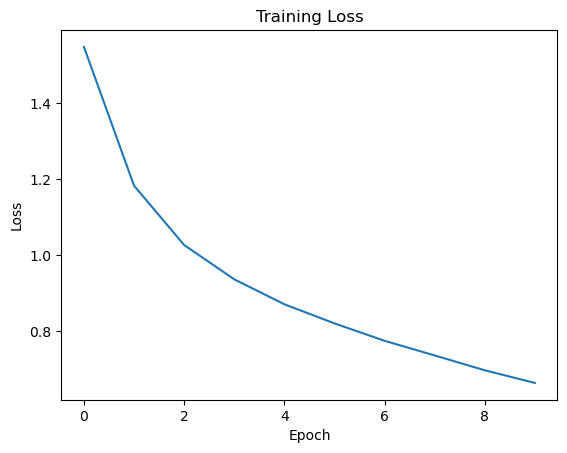

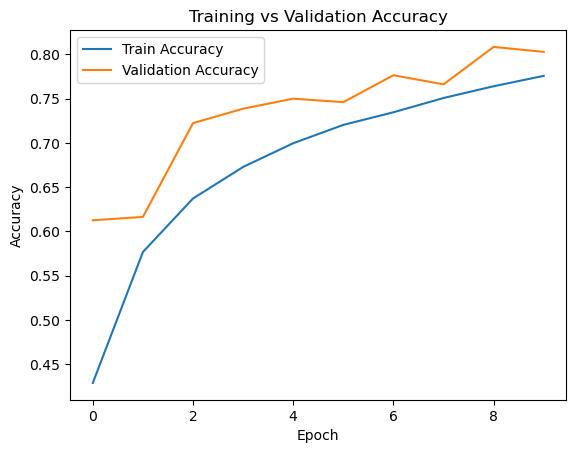

In [26]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
